<a href="https://colab.research.google.com/github/pipuf/ml_dev_cert/blob/main/13_1_6_THEORY_Color_Quantization_using_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Color Quantization using K-Means

Performs a pixel-wise Vector Quantization (VQ) of an image of the summer palace (China), reducing the number of colors required to show the image from 96,615 unique colors to 64, while preserving the overall appearance quality.

In this example, pixels are represented in a 3D-space and K-means is used to find 64 color clusters. In the image processing literature, the codebook obtained from K-means (the cluster centers) is called the color palette. Using a single byte, up to 256 colors can be addressed, whereas an RGB encoding requires 3 bytes per pixel. The GIF file format, for example, uses such a palette.

For comparison, a quantized image using a random codebook (colors picked up randomly) is also shown.

In [ ]:
from time import time

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 12]


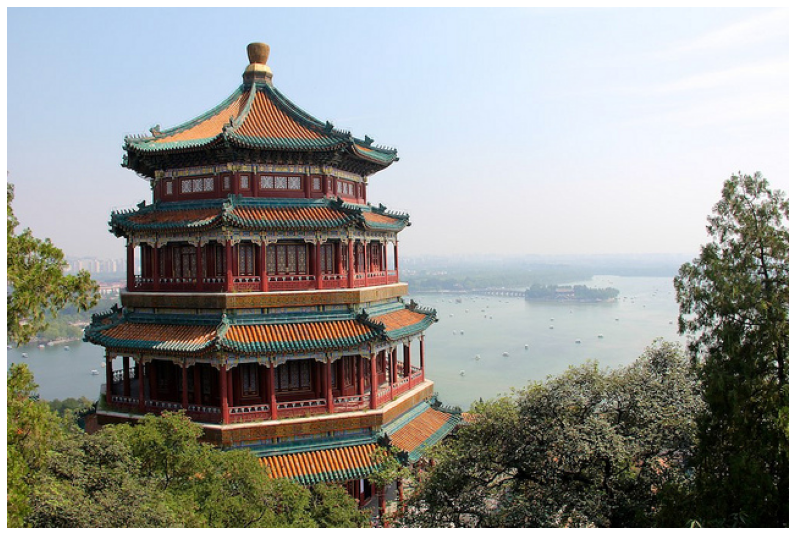

In [ ]:
# Load the Summer Palace photo
plt.axis("off")
china = load_sample_image("china.jpg")
plt.imshow(china)


In [ ]:
type(china)

numpy.ndarray

In [ ]:
china.shape

(427, 640, 3)

In [ ]:
red_channel = china[:, :, 0]
red_channel.shape

(427, 640)

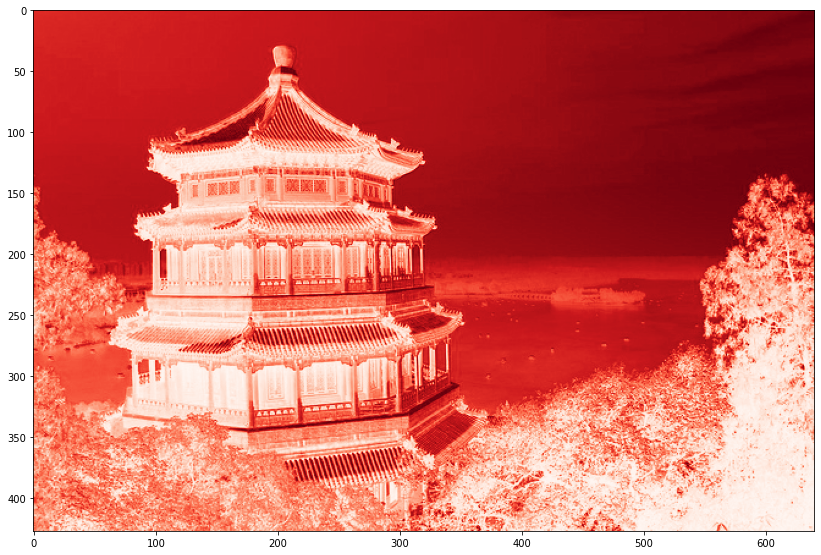

In [ ]:
plt.imshow(red_channel, cmap="Reds")

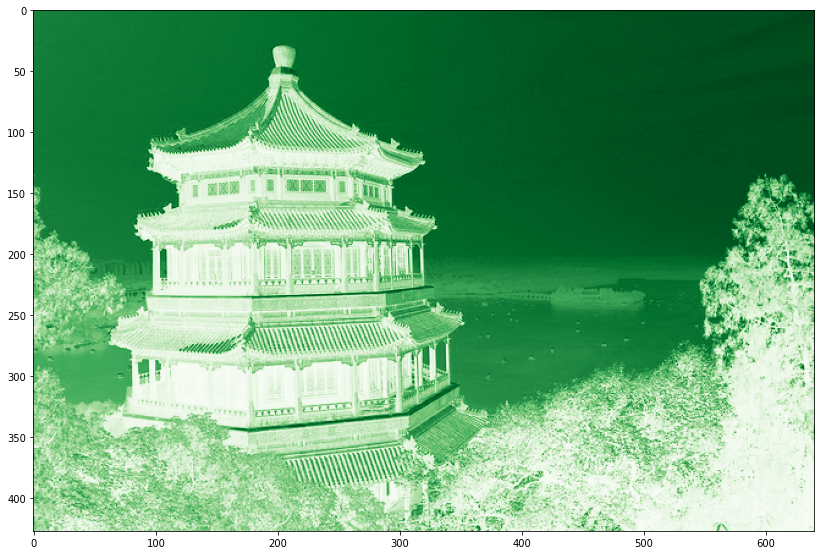

In [ ]:
plt.imshow(china[:, :, 1], cmap="Greens")

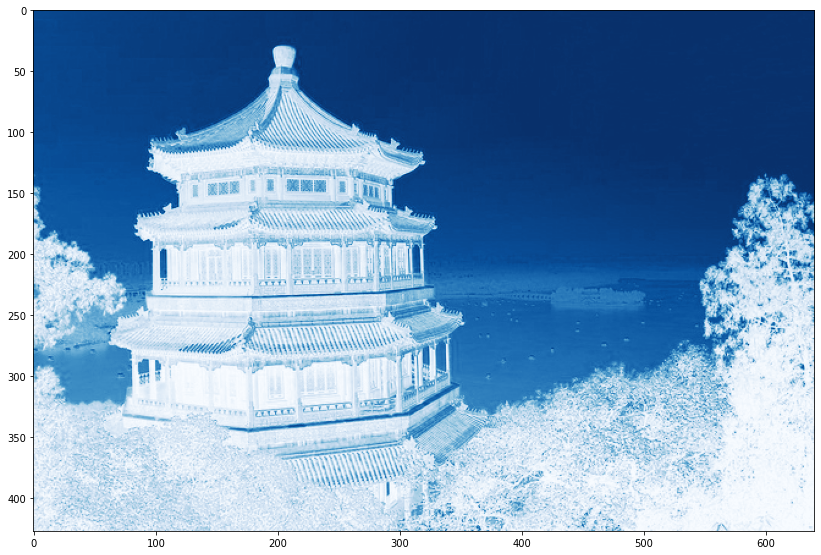

In [ ]:
plt.imshow(china[:, :, 2], cmap="Blues")

In [ ]:
china[100, 100] # Red Green Blue

array([192, 215, 233], dtype=uint8)

In [ ]:
h, w, ch = china.shape
h, w, ch

(427, 640, 3)

---
We can convert our image to a Pandas dataframe.

Each row will be a pixel and the columns will be the pixel value on each color channel (RGB format).

In [ ]:
china_array = china.reshape((h * w, ch))
china_df = pd.DataFrame(china_array, columns=["Red", "Green", "Blue"])
china_df

Red  Green  Blue
0       174    201   231
1       174    201   231
2       174    201   231
3       174    201   231
4       174    201   231
...     ...    ...   ...
273275    2      2     0
273276    9     11     6
273277   43     49    39
273278   13     21     6
273279   15     24     7

[273280 rows x 3 columns]

In [ ]:
# We can count how many unique colors do we have in the current image
china_df.drop_duplicates().shape

(96615, 3)

In [ ]:
"""
Red -> [0, 255]
Green -> [0, 255]
Blue -> [0, 255]
"""
256 ** 3

16777216

In [ ]:
china.shape

(427, 640, 3)

In [ ]:
image_array = np.reshape(china, (h * w, ch))
image_array.shape

(273280, 3)

In [ ]:
# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = china / 255

# Transform image to a 2D numpy array.
h, w, ch = china.shape
image_array = np.reshape(china, (h * w, ch))


In [ ]:
# Define how many output colors do we want (i.e. number of clusters)
n_colors = 64

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0, n_samples=10_000)
kmeans = KMeans(n_clusters=n_colors, random_state=0)
kmeans.fit(image_array_sample)
print(f"done in {time() - t0:0.3f}s.")


Fitting model on a small sub-sample of the data
done in 1.852s.


---
**Side note:** It's a good practice and improves readability writing large numbers using underscores ("_"). Examples:

- `1_000` it's the same as `1000`
- `10_000_000` it's the same as `10000000`

See:

- [PEP 0515](https://peps.python.org/pep-0515/)
- [StackOverflow](https://stackoverflow.com/questions/49837534/what-do-1-000-and-100-000-mean)

---

In [ ]:
# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print(f"done in {time() - t0:0.3f}s.")


Predicting color indices on the full image (k-means)
done in 0.139s.


In [ ]:
labels[1000:1100]

array([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 45, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,  0, 45,
       45, 45, 45, 45, 45, 45,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [ ]:
kmeans.cluster_centers_.shape

(64, 3)

In [ ]:
kmeans.cluster_centers_[:5]

array([[0.93547013, 0.95670218, 0.98635171],
       [0.38149211, 0.25576279, 0.22080344],
       [0.13845233, 0.13030983, 0.09956593],
       [0.69509804, 0.67749767, 0.62670401],
       [0.81301305, 0.84371729, 0.88067587]])

In [ ]:
def recreate_image(codebook, labels, h, w):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(h, w, -1)


In [ ]:
quantized_img = recreate_image(kmeans.cluster_centers_, labels, h, w)


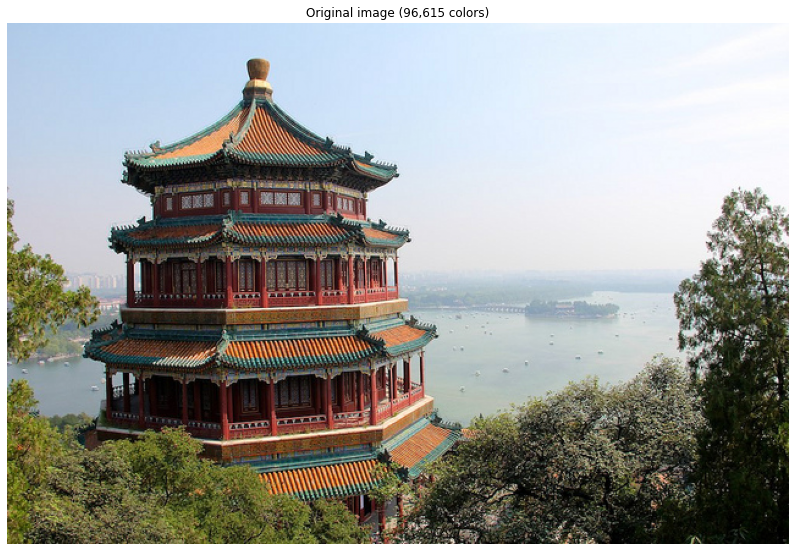

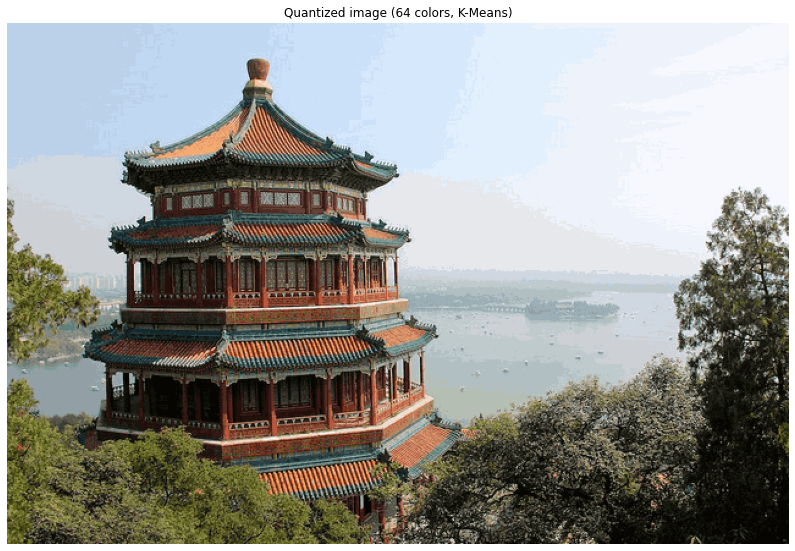

In [ ]:
# Display all results, alongside original image
plt.figure()
plt.clf()
plt.axis("off")
plt.title("Original image (96,615 colors)")
plt.imshow(china)

plt.figure()
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, K-Means)")
plt.imshow(quantized_img)

In [ ]:
"""
Calculate color compression rate:

96615 -> 100 %
64    -> x %
"""
compression_rate = 100 - 64 * 100 / 96615
print(f"Image colors compressed {compression_rate:.2f}% !")

Image colors compressed 99.93% !


---
Let's try choosing colors at random instead!

In [ ]:
codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
codebook_random.shape

In [ ]:
image_array.shape

In [ ]:
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
labels_random

In [ ]:
# Get n_colors colors
codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)

# Map each pixel to the closest color
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
print(f"done in {time() - t0:0.3f}s.")

In [ ]:
codebook_random.shape

In [ ]:
labels_random[1000:1100]

In [ ]:
plt.figure()
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, Random)")
plt.imshow(recreate_image(codebook_random, labels_random, h, w))
plt.show()

---
## Reference:

- [Scikit-learn: Color Quantization using K-Means](https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py)